Second try

In [ ]:
# mount the drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import pre-requisite
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
# Apply TPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

This is dataset transformation method for ResNet model. It first resize to 224x224 shape, Perform data augmentation, convert into Tensor, and Normalize. 

In [ ]:
# resize, Augment, and Normalize train dataset
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
# Perform same for test data set
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Give the directory of train and test dataset
train_dir = "/content/drive/MyDrive/Training Images/AIP_image/train/"
test_dir = "/content/drive/MyDrive/Training Images/AIP_image/test/"
# Load dataset and apply transformation on them
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
# Create a batch size of 12 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=2)
# Now print the number of train and test data
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Class names:', train_dataset.classes)

Train dataset size: 532
Test dataset size: 120
Class names: ['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


Now load pretrained model and replace last layer with containing number of classes.


In [ ]:
model = models.resnet18(pretrained=True)                                 # Load resnet18 model and keep pretrained=True inorder to fine tune it.
num_features = model.fc.in_features                                      # Extract fc layers features.
model.fc = nn.Linear(num_features, 6)                                    # Now put the input and output shape. Here number of features are input and classes are output.
model = model.to(device)                                                 # Pass it through TPU
criterion = nn.CrossEntropyLoss()                                        # Set cross entropy loss and SGD optimizer.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Our model and data is ready. Now we need to train it.

In [ ]:
# Initialize number of epoch
num_epochs = 20
# Define few list to plot accuracy and loss
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# Iterate model for given epochs  
for epoch in range(num_epochs):
    print("Epoch {} : ".format(epoch+1))
   
    # Initialize Model training, loss. 
    model.train()    
    running_loss = 0   
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Pass through device
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        # Max
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('Train Loss: {:.4f} Train Acc: {:.4f}%'.format(epoch_loss, epoch_acc))
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    # Initialize validation
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        # Load the test data and pass it through model
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)
        print('Test Loss: {:.4f} Test Acc: {:.4f}% '.format(epoch_loss, epoch_acc))

Epoch 1 : 
Train Loss: 1.2646 Train Acc: 51.6917%
Test Loss: 0.3710 Test Acc: 95.8333% 
Epoch 2 : 
Train Loss: 0.5347 Train Acc: 84.5865%
Test Loss: 0.2110 Test Acc: 95.0000% 
Epoch 3 : 
Train Loss: 0.4305 Train Acc: 84.9624%
Test Loss: 0.1910 Test Acc: 95.0000% 
Epoch 4 : 
Train Loss: 0.3449 Train Acc: 88.5338%
Test Loss: 0.2066 Test Acc: 93.3333% 
Epoch 5 : 
Train Loss: 0.3261 Train Acc: 88.3459%
Test Loss: 0.2353 Test Acc: 93.3333% 
Epoch 6 : 
Train Loss: 0.2773 Train Acc: 91.3534%
Test Loss: 0.2078 Test Acc: 92.5000% 
Epoch 7 : 
Train Loss: 0.2470 Train Acc: 92.2932%
Test Loss: 0.2069 Test Acc: 93.3333% 
Epoch 8 : 
Train Loss: 0.3181 Train Acc: 89.4737%
Test Loss: 0.2080 Test Acc: 92.5000% 
Epoch 9 : 
Train Loss: 0.2239 Train Acc: 93.6090%
Test Loss: 0.2501 Test Acc: 93.3333% 
Epoch 10 : 
Train Loss: 0.2531 Train Acc: 90.6015%
Test Loss: 0.2015 Test Acc: 93.3333% 
Epoch 11 : 
Train Loss: 0.2265 Train Acc: 92.1053%
Test Loss: 0.1880 Test Acc: 95.0000% 
Epoch 12 : 
Train Loss: 0.2248

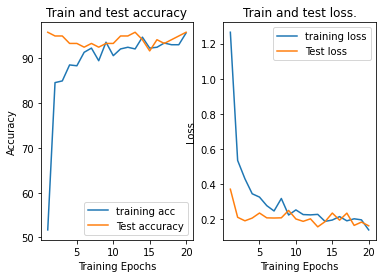

In [ ]:
# Plot the train and test accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs+1), train_acc)
plt.plot(range(1,num_epochs+1), test_acc)
plt.title("Train and test accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.legend(['training acc', 'Test accuracy'])

plt.subplot(1, 2, 2)
plt.plot(range(1,num_epochs+1), train_loss)
plt.plot(range(1,num_epochs+1), test_loss)
plt.title("Train and test loss.")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend(['training loss', 'Test loss'])
plt.show()

In [ ]:
# Save the trained model for further use. 
save_path = 'resnet18_trained_6.pth'
torch.save(model.state_dict(), save_path)

Inference the model

In [ ]:
# Load model and test accuracy
model.load_state_dict(torch.load("/content/resnet18_trained_6.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load test 
model.eval()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('Test Loss: {:.4f} Accuracy: {:.4f}% '.
          format(epoch_loss, epoch_acc))

Test Loss: 0.1626 Accuracy: 95.8333% 
